<a href="https://colab.research.google.com/github/mmadduri/BMI_Model/blob/brainAdaptOnly/Winter2020_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Start with this:**

Run the (***simple random search***) iteration

$$ u^+ = u - \frac{\gamma}{N} \sum_{n = 1}^N ( c(u + u_n) - c(u) ) \cdot u_n,\ u_n \sim \mathcal{N}(u,\sigma^2) $$

In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 


Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ \lambda^+ = \lambda - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(\lambda + \delta p) - error(\lambda) ) \cdot  p, p \sim \mathcal{N}(\lambda,\sigma^2) $$

In [0]:
mport numpy as np
import matplotlib.pyplot as plt


# Function that generates the adaptation

####################
# Brain Model 
def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
  # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
  targ_vect_mult = np.insert(targ_vect, 0, 1)
  return lambda_vect - (gamma*delta_perturb*targ_vect_mult)

def calcNextLambda_element(lambda_vect, gamma, delta_perturb, targ_vect):
  # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
  targ_vect_mult = np.insert(targ_vect, 0, 1)
  return lambda_vect - (gamma*np.multiply(delta_perturb, targ_vect_mult))

## lambda, t --> f
def brainFiringRate(lambda_vect, targ_vect):
  # f = b + Fwt 
  # [b w_x w_y]*[1 t_x  t_y ]'
  targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
  newFR = np.matmul(lambda_vect, targ_vect_mult) 
  return newFR

####################
# Decoder Model 
# K_matx = num neurons x num target 
K_matx = np.array([[0.5, 0.2]])

# keyword arguments--like a static variable (add states to function)
# make it's optional argument (kwargs)
# might have to make neurons_num global
# firing rate --> a + Kf --> y
## f --> y
def decoder_findY(firing_rate, targ_vect):
  global K_matx
  # D(f) = a + Kf = y
  # Start with affine decoder
  a_vect = np.multiply(firing_rate, 0.3)

  nextPred_vect = a_vect + np.dot(K_matx, np.squeeze(np.asarray(firing_rate)))
  return (nextPred_vect)

# Note to self: this function is returning a + Kf = y accurately
# ######
# define reach error
# y_x, y_y = matrix of predicted cursor position
# t_x, t_y = matrix of target position
def calcReachError(y_vect, t_vect):
  norm_vect = np.array(y_vect) - np.array(t_vect)
  return (np.linalg.norm(norm_vect, 2)**2)

def reachError_FR(firing_rate, targ_vect):
  y_vect = decoder_findY(firing_rate, targ_vect)
  t_vect = targ_vect
  return calcReachError(y_vect, t_vect)  


#########
## Related to Stochastic Gradient Descent


# find next g
# define random search

# this is only 1 iteration of SGD
# takes in a vector lambda 
# start with scalar case
def findErrorGrad_fr(fr_input, sigma, delta, targ_vect):
  N_sum = 0
  N_neurons = np.size(fr_input)
  N_samp = 100

  perturb_rand = np.random.normal(fr_input, sigma, N_samp)

  for iN in range(N_samp):
    N_sum = N_sum + (reachError_FR(fr_input + delta*perturb_rand[iN], targ_vect) - reachError_FR(fr_input, targ_vect))*perturb_rand[iN]

  errorGrad = N_sum/(N_samp*delta)
  # print(avgUpdate)
  return errorGrad

def findErrorGrad_lambda(lambda_input, sigma, delta, targ_vect):
  N_samp = 100
  lambda_size = np.size(lambda_input)
  errorGrad = np.zeros(lambda_size)
  lambda_perturb = np.zeros(lambda_size)
  perturb_rand = np.zeros(( lambda_size, N_samp ))


  for iL in range(lambda_size): 
    perturb_rand[iL, :] = np.random.normal(lambda_input[iL], sigma, N_samp) 
    N_sum = 0
    for iN in range(N_samp):
      # find lambda = lambda + p ~ N(0, o^2)
      lambda_perturb = lambda_input.copy()
      lambda_perturb[iL] = delta*perturb_rand[iL, iN]

      # find the delta error due to perturbation
      error_perturb = calcReachError(decoder_findY(brainFiringRate(lambda_perturb, targ_vect), targ_vect), targ_vect)
      error_input = calcReachError(decoder_findY(brainFiringRate(lambda_input, targ_vect), targ_vect), targ_vect)

      # keep track of the running sum
      N_sum = N_sum + (np.abs( error_perturb - error_input ))*perturb_rand[iL, iN]  
    errorGrad[iL] = N_sum/(N_samp*delta)
  
  # print(np.shape(errorGrad))
  return errorGrad

def gradDesc_lambda(fr_init, lambda_init, targ_vect, learn_rate, numIter, sigma, delta):
  lambda_vect = np.zeros((np.size(lambda_init), numIter))
  lambda_vect[:,0] = lambda_init

  fr_vect = np.zeros(numIter)
  fr_next = np.array(fr_init)
  fr_vect[0] = np.array(fr_next)


  err_vect = np.zeros(numIter)
  err_next = reachError_FR(fr_vect[-1], targ_vect)
  err_vect[0] = np.array(err_next)
  
  for iT in range(0, numIter-1, 1):
    # delta_perturb = \Delta_feedback term due to perturbation
    delta_perturb = findErrorGrad_lambda(lambda_vect[:, iT], sigma, delta, targ_vect)
    # print("delta perturb = " + str(delta_perturb))
    
    # lambda+ = lambda - learn_rate*delta_perturb
    lambda_next = calcNextLambda_element(lambda_vect[:, iT], learn_rate, delta_perturb, targ_vect)
    # print("next lambda = " + str(lambda_next))

    # # calculate new firing rate with lamdba+
    fr_next = np.abs(brainFiringRate(lambda_next, targ_vect)) 
    # print("fr_next = " + str(fr_next))

    # calculate new reach error with lamdba+ and fr+
    err_next = np.array(reachError_FR(fr_next, targ_vect))  
    # print("error next = " + str(err_next))


    # update vectors 
    fr_vect[iT+1] = fr_next
    err_vect[iT+1] = err_next
    lambda_vect[:, iT+1] = lambda_next


  it_idx = np.linspace(0, numIter, numIter, endpoint=False) 
  plt.figure()
  fig, ax = plt.subplots()

  ax.plot(it_idx, err_vect, label = 'RE')
  ax.plot(it_idx, fr_vect, label = 'FR') 
  leg = ax.legend();
  plt.grid()
  plt.title('Stoch Update')

  plt.figure()
  fig2, ax2 = plt.subplots()
  ax2.plot(it_idx, lambda_vect[0, :], label = 'b') 
  ax2.plot(it_idx, lambda_vect[1, :], label = 'Wx') 
  ax2.plot(it_idx, lambda_vect[2, :], label = 'Wy')
  leg = ax2.legend();
  plt.grid()
  plt.title('Stoch Update of Lambda')


# param vect = what to update 
def gradDesc_fr(fr_init, lambda_init, targ_vect, learn_rate, numIter, sigma, delta):
  lambda_vect = np.zeros((np.size(lambda_init), numIter))
  lambda_vect[:,0] = lambda_init

  fr_vect = np.zeros(numIter)
  fr_next = np.array(fr_init)
  fr_vect[0] = np.array(fr_next)


  err_vect = np.zeros(numIter)
  err_next = reachError_FR(fr_vect[-1], targ_vect)
  err_vect[0] = np.array(err_next)
  
  for iT in range(0, numIter-1, 1):
    # delta_perturb = \Delta_feedback term due to perturbation
    delta_perturb = findErrorGrad_fr(fr_init[:, iT], sigma, delta, targ_vect)
    # print("delta perturb = " + str(delta_perturb))
    
    # lambda+ = lambda - learn_rate*delta_perturb
    lambda_next = calcNextLambda(lambda_vect[:, iT], learn_rate, delta_perturb, targ_vect)
    # print("next lambda = " + str(lambda_next))

    # # calculate new firing rate with lamdba+
    fr_next = np.abs(brainFiringRate(lambda_next, targ_vect)) 
    # print("fr_next = " + str(fr_next))

    # calculate new reach error with lamdba+ and fr+
    err_next = np.array(reachError_FR(fr_next, targ_vect))  
    # print("error next = " + str(err_next))


    # update vectors 
    fr_vect[iT+1] = fr_next
    err_vect[iT+1] = err_next
    lambda_vect[:, iT+1] = lambda_next


  it_idx = np.linspace(0, numIter, numIter, endpoint=False) 
  plt.figure()
  fig, ax = plt.subplots()

  ax.plot(it_idx, err_vect, label = 'RE')
  ax.plot(it_idx, fr_vect, label = 'FR') 
  leg = ax.legend();
  plt.grid()
  plt.title('Stoch Update')

  plt.figure()
  fig2, ax2 = plt.subplots()
  ax2.plot(it_idx, lambda_vect[0, :], label = 'b') 
  ax2.plot(it_idx, lambda_vect[1, :], label = 'Wx') 
  ax2.plot(it_idx, lambda_vect[2, :], label = 'Wy')
  leg = ax2.legend();
  plt.grid()
  plt.title('Stoch Update of Lambda')

#### Code

##### TESTING ONLY
# define c, D1_c, D2_c
def cost(u):
  return ((u**6)/6) - (7/5 * u**5) + (17/4 * u**4) - (17/3 * u**3) + (3 * u**2)
def D1_c(u):
  return ((u**5) - (7 * u**4) + (17 * u**3) - (17 * u**2) + (6 * u**1))
def D2_c(u):
  return ((5 * u**4) - (7*4 * u** 3) + (17*3 * u**2) - (17*2 * u) + (6))

#define gradient descent 
def gradDesc_cont(rate, it_num, u_init):
  u_new = [u_init]
  c_new = [cost(u_new[-1])]
  for it in range(1,it_num,1):
    u_new.append(u_new[-1] - rate*D1_c(u_new[-1]))
    c_new.append(cost(u_new[-1]))
  it_idx = np.linspace(0,it_num, it_num, endpoint=False) 
  plt.figure()
  plt.plot(it_idx, c_new)
  plt.plot(it_idx, u_new)

# # Set initial conditions

# #######
# Set initial conditions
learn_rate = 0.5
numIter = 40
fr_init = [0.5]
lambda_init = np.array([0.1, 0.4, 3])
sigma = 0.01 # Note about sigma: Anything >0.1 does not converge
delta = 1

TARGET_NUM = 2
TARGET_VECTOR = [2, 2]
gradDesc_lambda(fr_init, lambda_init, TARGET_VECTOR, learn_rate, numIter, sigma, delta)

##

# print(findErrorGrad_lambda(lambda_init, sigma, delta, TARGET_VECTOR))

##### TESTING ONLY
# rate = 0.1
# u_init = 0.5
# gradDesc_cont(rate, numIter, u_init)
# plt.legend({'c', 'u'})
# plt.grid()

# e1 = decoder_findY(u_init, TARGET_VECTOR)
# print(e1)
# print(reachError_FR(u_init, TARGET_VECTOR))
# print(np.linalg.norm(e1, 2)**2)

<Figure size 432x288 with 0 Axes>

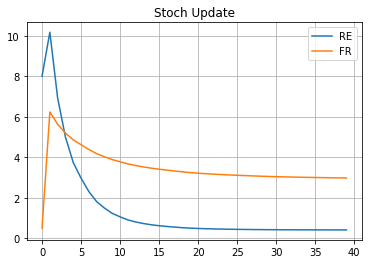

<Figure size 432x288 with 0 Axes>

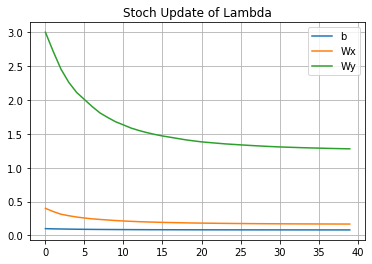

In [102]:
import numpy as np
import matplotlib.pyplot as plt


# Function that generates the adaptation



####################
# Brain Model 
def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
  # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
  targ_vect_mult = np.insert(targ_vect, 0, 1)
  return lambda_vect - (gamma*delta_perturb*targ_vect_mult)

def calcNextLambda_element(lambda_vect, gamma, delta_perturb, targ_vect):
  # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
  targ_vect_mult = np.insert(targ_vect, 0, 1)
  return lambda_vect - (gamma*np.multiply(delta_perturb, targ_vect_mult))

## lambda, t --> f
def brainFiringRate(lambda_vect, targ_vect):
  # f = b + Fwt 
  # [b w_x w_y]*[1 t_x  t_y ]'
  targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
  newFR = np.matmul(lambda_vect, targ_vect_mult) 
  return newFR

####################
# Decoder Model 
# K_matx = num neurons x num target 
K_matx = np.array([[0.5, 0.2]])

# keyword arguments--like a static variable (add states to function)
# make it's optional argument (kwargs)
# might have to make neurons_num global
# firing rate --> a + Kf --> y
## f --> y
def decoder_findY(firing_rate, targ_vect):
  global K_matx
  # D(f) = a + Kf = y
  # Start with affine decoder
  a_vect = np.multiply(firing_rate, 0.3)

  nextPred_vect = a_vect + np.dot(K_matx, np.squeeze(np.asarray(firing_rate)))
  return (nextPred_vect)

# Note to self: this function is returning a + Kf = y accurately
# ######
# define reach error
# y_x, y_y = matrix of predicted cursor position
# t_x, t_y = matrix of target position
def calcReachError(y_vect, t_vect):
  norm_vect = np.array(y_vect) - np.array(t_vect)
  return (np.linalg.norm(norm_vect, 2)**2)

def reachError_FR(firing_rate, targ_vect):
  y_vect = decoder_findY(firing_rate, targ_vect)
  t_vect = targ_vect
  return calcReachError(y_vect, t_vect)  

# find next g
# define random search

# this is only 1 iteration of SGD
# takes in a vector lambda 
# start with scalar case
def findErrorGrad_fr(fr_input, sigma, delta, targ_vect):
  N_sum = 0
  N_neurons = np.size(fr_input)
  N_samp = 100

  perturb_rand = np.random.normal(fr_input, sigma, N_samp)

  for iN in range(N_samp):
    N_sum = N_sum + (reachError_FR(fr_input + delta*perturb_rand[iN], targ_vect) - reachError_FR(fr_input, targ_vect))*perturb_rand[iN]

  errorGrad = N_sum/(N_samp*delta)
  # print(avgUpdate)
  return errorGrad

def findErrorGrad_lambda(lambda_input, sigma, delta, targ_vect):
  N_samp = 100
  lambda_size = np.size(lambda_input)
  errorGrad = np.zeros(lambda_size)
  lambda_perturb = np.zeros(lambda_size)
  perturb_rand = np.zeros(( lambda_size, N_samp ))


  for iL in range(lambda_size): 
    perturb_rand[iL, :] = np.random.normal(lambda_input[iL], sigma, N_samp) 
    N_sum = 0
    for iN in range(N_samp):
      # find lambda = lambda + p ~ N(0, o^2)
      lambda_perturb = lambda_input.copy()
      lambda_perturb[iL] = delta*perturb_rand[iL, iN]

      # find the delta error due to perturbation
      error_perturb = calcReachError(decoder_findY(brainFiringRate(lambda_perturb, targ_vect), targ_vect), targ_vect)
      error_input = calcReachError(decoder_findY(brainFiringRate(lambda_input, targ_vect), targ_vect), targ_vect)

      # keep track of the running sum
      N_sum = N_sum + (np.abs( error_perturb - error_input ))*perturb_rand[iL, iN]  
    errorGrad[iL] = N_sum/(N_samp*delta)
  
  # print(np.shape(errorGrad))
  return errorGrad

def gradDesc_lambda(fr_init, lambda_init, targ_vect, learn_rate, numIter, sigma, delta):
  lambda_vect = np.zeros((np.size(lambda_init), numIter))
  lambda_vect[:,0] = lambda_init

  fr_vect = np.zeros(numIter)
  fr_next = np.array(fr_init)
  fr_vect[0] = np.array(fr_next)


  err_vect = np.zeros(numIter)
  err_next = reachError_FR(fr_vect[-1], targ_vect)
  err_vect[0] = np.array(err_next)
  
  for iT in range(0, numIter-1, 1):
    # delta_perturb = \Delta_feedback term due to perturbation
    delta_perturb = findErrorGrad_lambda(lambda_vect[:, iT], sigma, delta, targ_vect)
    # print("delta perturb = " + str(delta_perturb))
    
    # lambda+ = lambda - learn_rate*delta_perturb
    lambda_next = calcNextLambda_element(lambda_vect[:, iT], learn_rate, delta_perturb, targ_vect)
    # print("next lambda = " + str(lambda_next))

    # # calculate new firing rate with lamdba+
    fr_next = np.abs(brainFiringRate(lambda_next, targ_vect)) 
    # print("fr_next = " + str(fr_next))

    # calculate new reach error with lamdba+ and fr+
    err_next = np.array(reachError_FR(fr_next, targ_vect))  
    # print("error next = " + str(err_next))


    # update vectors 
    fr_vect[iT+1] = fr_next
    err_vect[iT+1] = err_next
    lambda_vect[:, iT+1] = lambda_next


  it_idx = np.linspace(0, numIter, numIter, endpoint=False) 
  plt.figure()
  fig, ax = plt.subplots()

  ax.plot(it_idx, err_vect, label = 'RE')
  ax.plot(it_idx, fr_vect, label = 'FR') 
  leg = ax.legend();
  plt.grid()
  plt.title('Stoch Update')

  plt.figure()
  fig2, ax2 = plt.subplots()
  ax2.plot(it_idx, lambda_vect[0, :], label = 'b') 
  ax2.plot(it_idx, lambda_vect[1, :], label = 'Wx') 
  ax2.plot(it_idx, lambda_vect[2, :], label = 'Wy')
  leg = ax2.legend();
  plt.grid()
  plt.title('Stoch Update of Lambda')


# param vect = what to update 
def gradDesc_fr(fr_init, lambda_init, targ_vect, learn_rate, numIter, sigma, delta):
  lambda_vect = np.zeros((np.size(lambda_init), numIter))
  lambda_vect[:,0] = lambda_init

  fr_vect = np.zeros(numIter)
  fr_next = np.array(fr_init)
  fr_vect[0] = np.array(fr_next)


  err_vect = np.zeros(numIter)
  err_next = reachError_FR(fr_vect[-1], targ_vect)
  err_vect[0] = np.array(err_next)
  
  for iT in range(0, numIter-1, 1):
    # delta_perturb = \Delta_feedback term due to perturbation
    delta_perturb = findErrorGrad_fr(fr_init[:, iT], sigma, delta, targ_vect)
    # print("delta perturb = " + str(delta_perturb))
    
    # lambda+ = lambda - learn_rate*delta_perturb
    lambda_next = calcNextLambda(lambda_vect[:, iT], learn_rate, delta_perturb, targ_vect)
    # print("next lambda = " + str(lambda_next))

    # # calculate new firing rate with lamdba+
    fr_next = np.abs(brainFiringRate(lambda_next, targ_vect)) 
    # print("fr_next = " + str(fr_next))

    # calculate new reach error with lamdba+ and fr+
    err_next = np.array(reachError_FR(fr_next, targ_vect))  
    # print("error next = " + str(err_next))


    # update vectors 
    fr_vect[iT+1] = fr_next
    err_vect[iT+1] = err_next
    lambda_vect[:, iT+1] = lambda_next


  it_idx = np.linspace(0, numIter, numIter, endpoint=False) 
  plt.figure()
  fig, ax = plt.subplots()

  ax.plot(it_idx, err_vect, label = 'RE')
  ax.plot(it_idx, fr_vect, label = 'FR') 
  leg = ax.legend();
  plt.grid()
  plt.title('Stoch Update')

  plt.figure()
  fig2, ax2 = plt.subplots()
  ax2.plot(it_idx, lambda_vect[0, :], label = 'b') 
  ax2.plot(it_idx, lambda_vect[1, :], label = 'Wx') 
  ax2.plot(it_idx, lambda_vect[2, :], label = 'Wy')
  leg = ax2.legend();
  plt.grid()
  plt.title('Stoch Update of Lambda')

#### Code

##### TESTING ONLY
# define c, D1_c, D2_c
def cost(u):
  return ((u**6)/6) - (7/5 * u**5) + (17/4 * u**4) - (17/3 * u**3) + (3 * u**2)
def D1_c(u):
  return ((u**5) - (7 * u**4) + (17 * u**3) - (17 * u**2) + (6 * u**1))
def D2_c(u):
  return ((5 * u**4) - (7*4 * u** 3) + (17*3 * u**2) - (17*2 * u) + (6))

#define gradient descent 
def gradDesc_cont(rate, it_num, u_init):
  u_new = [u_init]
  c_new = [cost(u_new[-1])]
  for it in range(1,it_num,1):
    u_new.append(u_new[-1] - rate*D1_c(u_new[-1]))
    c_new.append(cost(u_new[-1]))
  it_idx = np.linspace(0,it_num, it_num, endpoint=False) 
  plt.figure()
  plt.plot(it_idx, c_new)
  plt.plot(it_idx, u_new)

# # Set initial conditions

# #######
# Set initial conditions
learn_rate = 0.5
numIter = 40
fr_init = [0.5]
lambda_init = np.array([0.1, 0.4, 3])
sigma = 0.01 # Note about sigma: Anything >0.1 does not converge
delta = 1

TARGET_NUM = 2
TARGET_VECTOR = [2, 2]
gradDesc_lambda(fr_init, lambda_init, TARGET_VECTOR, learn_rate, numIter, sigma, delta)

##

# print(findErrorGrad_lambda(lambda_init, sigma, delta, TARGET_VECTOR))

##### TESTING ONLY
# rate = 0.1
# u_init = 0.5
# gradDesc_cont(rate, numIter, u_init)
# plt.legend({'c', 'u'})
# plt.grid()

# e1 = decoder_findY(u_init, TARGET_VECTOR)
# print(e1)
# print(reachError_FR(u_init, TARGET_VECTOR))
# print(np.linalg.norm(e1, 2)**2)